In [13]:
import pandas as pd
from IPython.display import Image

from alpaca.data import StockHistoricalDataClient
from alpaca.trading.client import TradingClient
from alpaca.data.requests import StockLatestQuoteRequest
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

#### Alpaca account

After logging in to Alpaca, you DO NOT need to enter name, address, etc. - that is only for real trading accounts.  By clicking the Overview icon on the left toolbar, you should get to the following screen.  Click on API Keys, then Regenerate to see your key and your secret key.  Copy and save them somewhere.

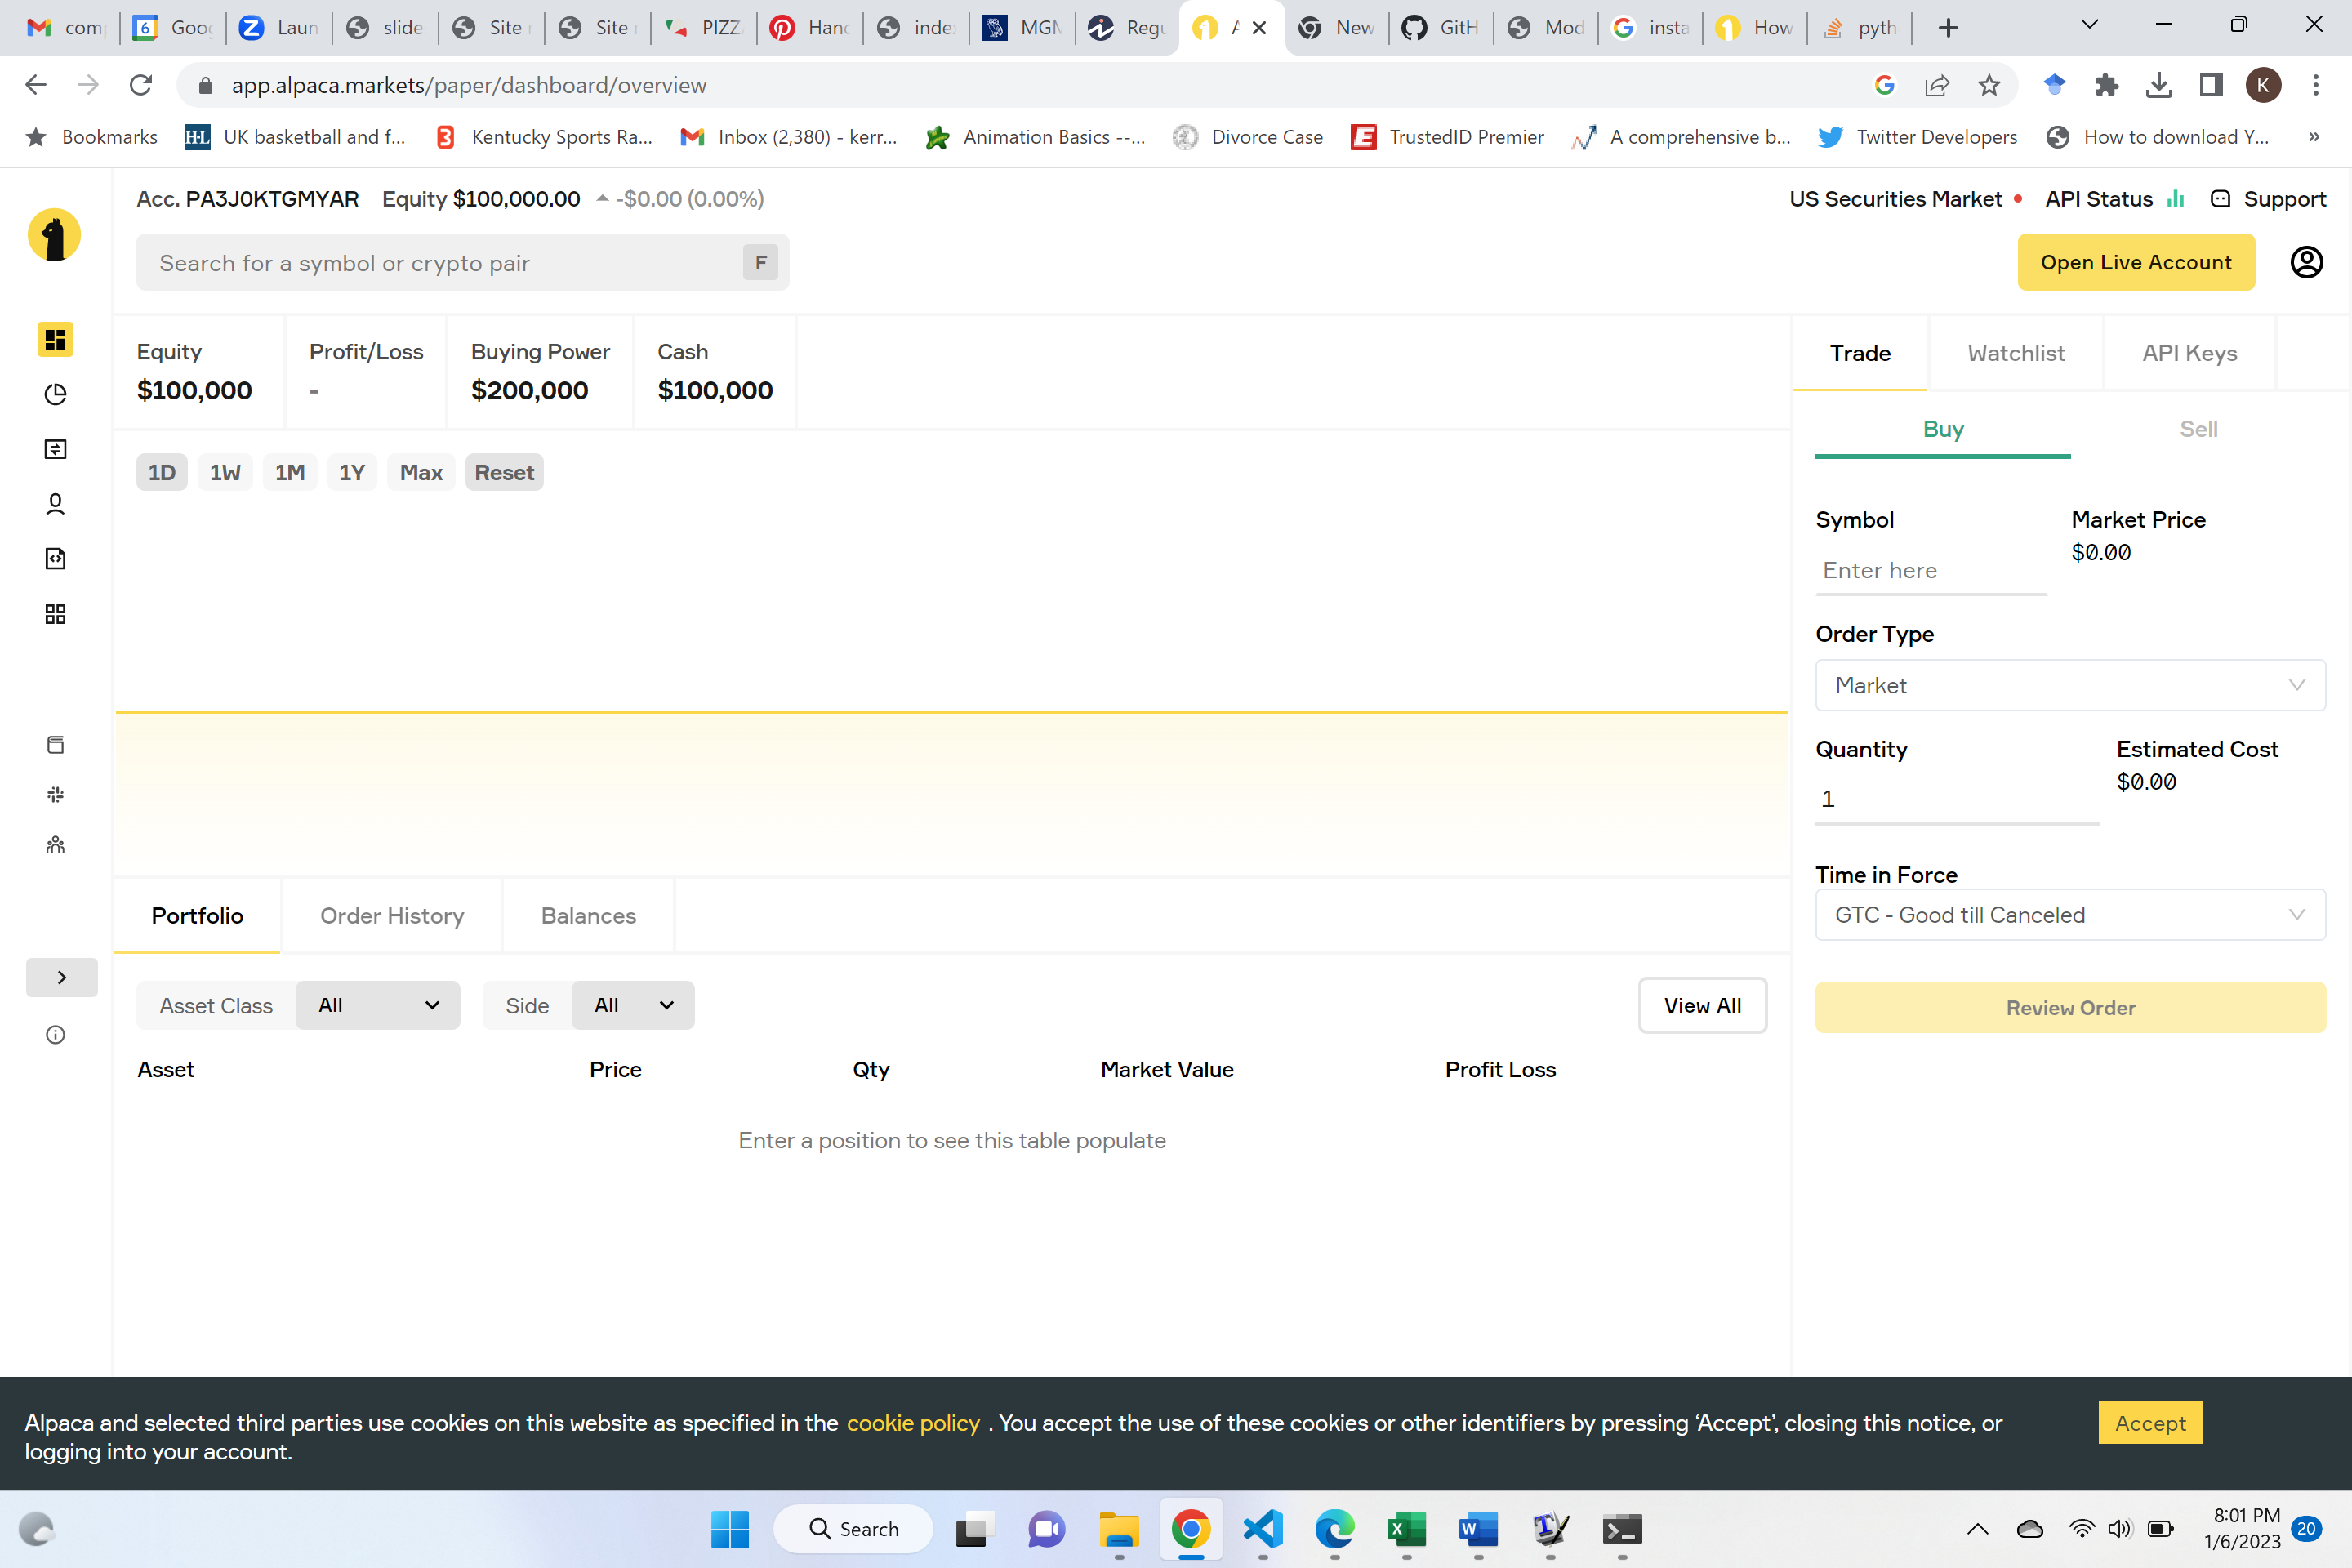

In [14]:

Image(filename='files/alpaca1.png') 

#### Alpaca python module

The module alpaca-trade-api is deprecated.  Install alpaca-py instead. The documentation is at https://alpaca.markets/docs/python-sdk/getting_started.html.    Substitute your key and secret key in the following.

In [15]:
KEY = "PKS7I0GX04CUGYTZ4ND7"
SECRET_KEY = "coYG5T8j3DvnJ9drddFiz3TxvAdFaqItEKw4qKYr"

data_client = StockHistoricalDataClient(KEY, SECRET_KEY)
trading_client = TradingClient(KEY, SECRET_KEY, paper=True)

#### Tickers we want to trade

In [16]:
top = pd.read_csv("files/top.csv")
ticks = top.ticker.to_list()

#### Get quotes for tickers

In [17]:
params = StockLatestQuoteRequest(symbol_or_symbols=ticks)
quotes = data_client.get_stock_latest_quote(params)

# convert to dataframe

sers = [pd.Series(dict(x)) for x in quotes.values()]
df = pd.concat(sers, axis=1)
df.columns = [x for x in quotes]
df = df.T
df = df.drop(columns=["symbol"])
df

,timestamp,ask_exchange,ask_price,ask_size,bid_exchange,bid_price,bid_size,conditions,tape
ORMP,2023-01-06 21:00:00.005188+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
TBBK,2023-01-06 21:00:00.005814+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
TPH,2023-01-06 21:00:00.003719+00:00,V,0.0,0.0,V,0.0,0.0,[R],A
IIIN,2023-01-06 21:00:00.004680+00:00,V,0.0,0.0,V,0.0,0.0,[R],A
ZYXI,2023-01-06 21:00:00.013216+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
...,...,...,...,...,...,...,...,...,...
PLBC,2023-01-06 21:00:00.008776+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
KE,2023-01-06 21:00:00.011353+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
HIBB,2023-01-06 21:00:00.005878+00:00,V,0.0,0.0,V,0.0,0.0,[R],C
BGSF,2023-01-06 20:25:59.126229+00:00,V,15.82,1.0,V,15.05,1.0,[R],A


#### Compute # of shares to trade

In [18]:
df["trade"] = df.ask_price.apply(lambda p: int(1000/p) if p !=0 else 0)
ticks = df[df.trade>0].index.to_list()

In [19]:
for tick in ticks: 
    market_order_data = MarketOrderRequest(
        symbol=tick,
        qty=df.trade.loc[tick],
        side=OrderSide.BUY,
        time_in_force=TimeInForce.DAY
    )
    market_order = trading_client.submit_order(
        order_data=market_order_data
    )